# 变量设置

In [6]:
# 设置数据集名称，对应 https://xenabrowser.net/datapages/ 中缩写
dataset_name =  ['OV']
# 设置俩： ['LUAD', 'LUSC']
# 更多更多也行
# 单一个： ['LUAD'] 
# All possible Value:
# ['ACC','CHOL','BLCA','BRCA','CESC','COAD','UCEC','ESCA','GBM','HNSC','KICH','KIRC','KIRP','DLBC','LIHC','LGG','LUAD','LUSC','SKCM','MESO','UVM','OV','PAAD','PCPG','PRAD','READ','SARC','STAD','TGCT','THYM','THCA','UCS']:
method = 'normal' # diff是上面俩数据集的差异，normal是和正常样本的差异
# method = 'diff'
loglevel = ''
# loglevel = 'debug'

balance_input = 'true' # or true 
rate1 = 0.0 # 在0里面混多少不是这个的1


# 数据导入

## 库

In [7]:
import requests
import os
import gzip
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn import datasets
import warnings
import GEOparse
from typing import Tuple, List
from sklearn.metrics import  roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix,fbeta_score
from imblearn.over_sampling import SMOTE, SMOTEN
sm = SMOTEN(random_state=42)
from multiprocessing import Pool, cpu_count
import ast
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, RidgeClassifier, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, ElasticNet,ElasticNetCV,SGDClassifier,RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC, NuSVC
from IPython.display import display, HTML
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

In [8]:
def download_and_parse_data(dataset_name):
    pkl_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna_transposed.pkl'
    if os.path.exists(pkl_file_path):
        df_t = pd.read_pickle(pkl_file_path)
    else:
        url = "https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-" + dataset_name + ".mirna.tsv.gz"
        response = requests.get(url)
        os.makedirs('./datasets', exist_ok=True)
        gz_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv.gz'
        with open(gz_file_path, 'wb') as f_out:
            f_out.write(response.content)
        tsv_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv'
        with gzip.open(gz_file_path, 'rb') as f_in:
            with open(tsv_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        df = pd.read_csv(tsv_file_path, sep='\t')
        df_t = df.transpose()
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop(df_t.index[0])
        df_t = np.power(2, df_t) - 1
        df_t = df_t.round(4)
        df_t['Status'] = df_t.index.map(lambda x: 1 if x.split('-')[3][:2] == '01' else 0)
        df_t = df_t[['Status'] + [col for col in df_t.columns if col != 'Status']]
        df_t.to_pickle(pkl_file_path)
        os.remove(gz_file_path)
        os.remove(tsv_file_path)
    df_t = df_t.apply(pd.to_numeric)
    return df_t

def find_healthy_samples(df):
    healthy_samples_df = df[df['Status'] == 0]
    return healthy_samples_df

In [9]:
# balance_data
def getStatus0data():
    Status0data = pd.DataFrame()
    Status1data = pd.DataFrame()
    for datasets in ['LAML','ACC','CHOL','BLCA','BRCA','CESC','COAD','UCEC','ESCA','GBM','HNSC','KICH','KIRC','KIRP','DLBC','LIHC','LGG','LUAD','LUSC','SKCM','MESO','UVM','OV','PAAD','PCPG','PRAD','READ','SARC','STAD','TGCT','THYM','THCA','UCS']:
        if datasets in dataset_name:
            continue
        try:
            # use download_and_parse_data to download the data
            dataframe = download_and_parse_data(datasets)
            # 把Status为0的dataframe赋值给Status0data
            Status0data = pd.concat([Status0data, dataframe[dataframe['Status'] == 0]])
            Status1data = pd.concat([Status1data, dataframe[dataframe['Status'] == 1]])
        except:
            print('Error:', datasets)
            continue

    # 混入对应比例的1
    # Status0data = pd.concat([Status0data, Status1data.sample(len(Status0data)*rate1/(1-rate1))])
    # int is needed
    Status0data = pd.concat([Status0data, Status1data.sample(n=int(len(Status0data)*rate1/(1-rate1)),random_state=42)])
    # 把所有的label 都设为0
    Status0data['Status'] = 0
    # 保存0的dataframe为pkl文件
    pkl_file_path = './datasets/Status0data.pkl'
    Status0data.to_pickle(pkl_file_path)

    return Status0data

def balance_data(Currentdata):
    # Get the count of Status=0 and Status=1
    current1 = Currentdata[Currentdata['Status'] == 1]
    current0 = Currentdata[Currentdata['Status'] == 0]
    
    if len(current0) > len(current1):
        print('0 is more than 1')
        # No need to balance, return the original DataFrame
        return Currentdata
    else:
        print('1 is more than 0')
        # If 1 is more, randomly sample from Status=0 data and concatenate
        Status0data = getStatus0data()
        balanced_data = pd.concat([current1, Status0data.sample(n=min(len(current1) - len(current0),len(Status0data)),random_state=42)])
        print('Currentdata.shape:', balanced_data.shape)
        return balanced_data

def balance_data2(Currentdata):
    # Get the count of Status=0 and Status=1
    current1 = Currentdata[Currentdata['Status'] == 1]
    current0 = Currentdata[Currentdata['Status'] == 0]
    
    if len(current0) > len(current1):
        print('0 is more than 1')
        # No need to balance, return the original DataFrame
        return Currentdata
    else:
        print('1 is more than 0')
        # If 1 is more, randomly remove some Status=1 data and concatenate
        balanced_data = pd.concat([current0, current1.sample(n=len(current0),random_state=42)])
        print('Currentdata.shape:', balanced_data.shape)
        return balanced_data




In [10]:
if method == "diff":
    dataA = download_and_parse_data(dataset_name[0])
    dataB = download_and_parse_data(dataset_name[1])

    A_up = dataA[dataA['Status'] == 1]
    B_up = dataB[dataB['Status'] == 1]

    B_up['Status'] = 0
    df_transposed = pd.concat([A_up, B_up], ignore_index=True)
elif method == "normal":
    df_transposed = pd.DataFrame()
    for name in dataset_name:
        df_transposed = df_transposed.append(download_and_parse_data(name))

# if balance_input, we need to balance the data using different datasets.
if balance_input == 'true':
    df_transposed = balance_data(df_transposed)
    
train_data = df_transposed.apply(pd.to_numeric)

1 is more than 0
Currentdata.shape: (972, 1882)


## 函数 准备

#### 定义存储结果的DataFrame

In [11]:
final_results = pd.DataFrame(columns=['method', 'model', 'n', 'acc', 'auc', 'f1', 'precision', 'recall', 'confusionmatrix','coef', 'coef_rounded', 'found_coef', 'multiple_times','intercept', 'miRNA_ID'])

#### 可接受的权重的范围筛选器

In [12]:
def get_allowed_numbers(max_n=25,allowed_factors=[1,2,3,4,5]):
    # 100 以内的整数
    result = range(1,100)
    return result

def is_all_in_list(list,n=25,allowed_factors=[2,3,5]):
    for i in list:
        if i not in get_allowed_numbers(n,allowed_factors):
            return False
    return list

### 画图

分数分布图

In [13]:
plot_labels = ['得了', '没得']

In [14]:
def plot_score_distribution(ax, y_score, final_Status):                                 # 这个函数负责处理分数分布图这一个小图
    ax.scatter(range(len(y_score)), y_score, c=final_Status, cmap='bwr', alpha=0.5)     # 画散点图，x轴是样本序号，y轴是分数，颜色是感染情况，颜色映射是蓝白红，透明度是0.5
                                                                                        # x是样本序号：分开画，免得都黏在一起了，透明度的设置是一样的原因。
    ax.set_title('分数分布图')
    ax.set_xlabel('样本序号')
    ax.set_ylabel('分数')
    plt.rcParams['font.sans-serif']=['SimHei']                                          # 中文乱码
    plt.rcParams['axes.unicode_minus']=False                                            # 负号乱码
    labels = plot_labels                                                                # 图例标签，这里是感染情况，以后如果换了的话得改。 #todo 将这个改为传入参数
    ax.legend(labels, loc='upper right')                                                # 图例
    ax.plot([0, len(y_score)], [0.5, 0.5], color='black', lw=1, linestyle='--')         # 以0.5为界，画一条虚线，表示分数大于0.5的是细菌感染，小于0.5的是病毒感染，这个以后也得改
                                                                                        # 因为不同的模型（如linear regression 和 ridge regression）的判断标准不一样，所以这个界限也不一样。
                                                                                        # 现在的做法是直接在y_score 上做手脚，还是……蛮不优雅的，但是先这样吧。
                                                                                        # todo 将这个改为传入参数

ROC曲线

In [15]:
def plot_roc_curve(ax, y_score, final_Status):
    from sklearn.metrics import auc
    fpr, tpr, thresholds = roc_curve(final_Status, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate 假阳性率')
    ax.set_ylabel('True Positive Rate 真阳性率')
    ax.set_title('ROC 曲线（受试者工作特征曲线）')
    ax.legend(loc="lower right")

PR曲线

In [16]:
def plot_pr_curve(ax, y_score, final_Status):
    precision, recall, thresholds = precision_recall_curve(final_Status, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
    ax.set_xlabel('Recall 召回率')
    ax.set_ylabel('Precision 准确率')
    ax.set_title('PR 曲线（准确率-召回率曲线）')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left")

混淆矩阵

In [17]:
def plot_confusion_matrix(ax, y_score, final_Status):
    y_pred = np.where(y_score > 0.5, 1, 0)
    cnf_matrix = confusion_matrix(final_Status, y_pred)
    ax.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.Blues) # type: ignore
    ax.set_title('Confusion Matrix 混淆矩阵')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, plot_labels, rotation=45)
    plt.yticks(tick_marks, plot_labels)
    thresh = cnf_matrix.max() / 2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j],horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label 感染情况')
    plt.xlabel('Predicted label 预测情况')

分数分布图、ROC曲线、PR曲线和混淆矩阵

In [18]:
def plot_all(score, Status, title="分数分布图、ROC曲线、PR曲线和混淆矩阵", feature=None, weight=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))                                                     # 规定画布大小为1200*1200px，分成2*2的4个小图
    fig.suptitle(title, fontsize=16)                                                                    # 设置标题
    plot_score_distribution(axs[0,0], score, Status)                                                    # 第一个小图（左上角）是分数分布图 这里的axs[0,0]是指第一行第一列的小图，注意计数是从0开始的。
    plot_roc_curve(axs[0,1], score, Status)                                                             # 第二个小图（右上角）是ROC曲线
    plot_pr_curve(axs[1,0], score, Status)                                                              # 第三个小图（左下角）是PR曲线
    plot_confusion_matrix(axs[1,1], score, Status)                                                      # 第四个小图（右下角）是混淆矩阵
    if feature or weight:                                                                               # 如果有feature或者weight的话，就在图的下方加上文字
        try:
            # add margin at bottom
            fig.subplots_adjust(bottom=0.12)                                                            # 调整图的下边距，这样文字就不会挡住图了
            # add feature and weight at the bottom
            fig.text(0.5, 0.04, '使用feature:'+str(feature), ha='center', va='bottom', fontsize=12)     # 在图的下方加上文字，这里的0.5,0.04是指文字的位置，ha='center'是指文字居中，va='bottom'是指文字在底部，fontsize=12是指文字大小
            fig.text(0.5, 0.02, '对应权重:'+str(weight), ha='center', va='bottom', fontsize=8)          # 同上
        except:
            pass                                                                                        # 如果出错了就算了
    return fig, axs

##### 给定 基因 权重 和数据，计算分数并画图（可能需要修改）

### 筛选

筛选哪些基因比较有差异

In [19]:
def get_higher_columns(data, diff=2.0):
    data_mean = data.groupby('Status').mean()
    higher_columns = []
    higher_times = []
    for i in range(data_mean.shape[1]):
        if  diff*data_mean.iloc[0,i] < data_mean.iloc[1,i]  or data_mean.iloc[0,i] > diff*data_mean.iloc[1,i]:
            higher_columns.append(data_mean.columns[i])
            # 0
            if data_mean.iloc[0,i] == 0:
                higher_times.append(1e10)
            else:
                higher_times.append(data_mean.iloc[1,i]/data_mean.iloc[0,i])
    return higher_columns, higher_times

排序有差异的基因

In [20]:
def sort_higher_columns(data, higher_columns, higher_times):
    # sort the columns and times together
    data_higher_times, data_higher_columns = zip(*sorted(zip(higher_times, higher_columns), reverse=True))
    # convert data_higher_columns to list
    data_higher_columns = list(data_higher_columns)
    # add Status column to the top of data_higher_columns
    data_higher_columns.append('Status')
    # get the new data
    data_higher = data[data_higher_columns]
    return data_higher, data_higher_times

输出

In [21]:
def print_best_acc(test_acc, n, gene_symbol, coef):
    best_acc = max(test_acc)
    best_i = 0
    i = 0
    print('最好的准确率为：', best_acc)
    for acc in test_acc:
        if acc == best_acc:
            print('='*60)
            print('对应的特征数为：', n[i],'方法为：', methods[i // len(models)].__name__,'特征为：', gene_symbol[i])
            print('模型为：', models[i % len(models)],'特征权重为：', coef[i])
            weights_avg = np.mean(coef[i])
            new_coefs = []
            for j in range(len(coef[i])):
                # new_coefs.append(10*(coef[i][j]/weights_avg)) 保留2位小数
                # new_coefs.append(round(10*(coef[i][j]/weights_avg), 2)) type numpy.ndarray doesn't define __round__ method
                new_coefs.append(np.round(10*(coef[i][j]/weights_avg), 2))
            print('比例大致为：', new_coefs)
        i += 1

一次性完成基因筛选和模型训练
通过调控C，使用LogisticRegression or LinearSVC 一次性完成基因筛选和模型训练

In [22]:
def percent_to_color(percent: float) -> str:
    assert 0 <= percent <= 1, "Percent must be between 0 and 1"
    if percent >= 0.82:
        hue = int(120 - (1 - percent) * 4000 / 3)
    else:
        hue = 0
    saturation = 100  # 饱和度为100%
    lightness = 50  # 亮度为50%
    return f"hsl({hue}, {saturation}%, {lightness}%)"

def colored_text(text: str, percent: float) -> str:
    color = percent_to_color(percent)
    return f'<span style="color: {color}">{text}</span>'
def evaluate_classifier(clf, method, model, X_train, y_train, X_test, y_test, params):
    global final_results

    acc_scores, auc_scores, f1_scores, precision_scores, recall_scores, n_features = [], [], [], [], [], []

    for param in params:
        clf.set_params(**param)
        clf.fit(X_train, y_train)
        nonzero_coef_indices = np.flatnonzero(clf.coef_)  # Indices where coef_ != 0
        n = len(nonzero_coef_indices)
        y_pred = clf.predict(X_test)
        y_pred = np.array([1 if i > 0.5 else 0 for i in y_pred], dtype=int)
        
        if 1 <= n <= 20:
            cm = confusion_matrix(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            f2 = fbeta_score(y_test, y_pred, beta=2)
            f05 = fbeta_score(y_test, y_pred, beta=0.5)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            # acc = clf.score(X_test, y_test) if method is lasso or elasticnet, score is not accuracy
            acc = accuracy_score(y_test, y_pred)

            coef = clf.coef_
            # only use non-zero coef
            coef = coef[coef != 0]
            weights_avg = np.mean(np.abs(coef))
            max_times = 100 / np.max(np.abs(coef))
            multipletimes = [max_times]
            found_coef = False
            coef_roundeds = []
            deltas = []
            for multipletime in multipletimes:
                coef_rounded_t = []
                differences = []
                for coef_i in coef:
                    # 符号问题,先存符号
                    coef_i_sign = coef_i / np.abs(coef_i)
                    coef_i = np.abs(coef_i)
                    coef_rounded_t.append(coef_i * multipletime * coef_i_sign)
                    differences.append(0)  # 不再使用 allowed_numbers
                delta = np.average(np.array(differences))
                deltas.append(delta)
                coef_roundeds.append(coef_rounded_t)

            coef_rounded = coef_roundeds[np.argmin(deltas)]
            delta = np.min(deltas)
            mean_coef = np.mean(np.abs(coef_rounded))
            times = mean_coef / weights_avg
            if delta < 0.30: # 30%的平均误差
                found_coef = True
            if np.sum(coef_rounded) == 0:
                balanced = True
            else:
                balanced = False

            intercept = clf.intercept_

            nonzero_coef_indices = np.flatnonzero(clf.coef_) # get the indices of non-zero coef
            gene_id = list(X_train.columns[nonzero_coef_indices])

            result = pd.DataFrame({
                'method': [method],
                'model': [model],
                'n': [n],
                'acc': [acc],
                'auc': [auc],
                'f1': [f1],
                'f2': [f2],
                'f05': [f05],
                'precision': [precision],
                'recall': [recall],
                'confusionmatrix': [cm],
                'coef': [coef.tolist()],
                'coef_rounded': [coef_rounded],
                'found_coef': [found_coef],
                'delta': [delta],
                'multiple_times': [times],
                'intercept': [intercept.item()],
                'balanced': [balanced],
                'gene_id': [gene_id],
            })

            final_results = pd.concat([final_results, result], ignore_index=True) 

            # For plotting
            n_features.append(n) 
            acc_scores.append(acc)
            auc_scores.append(auc)
            f1_scores.append(f1)
            precision_scores.append(precision)
            recall_scores.append(recall)

            if loglevel == 'debug':
                result_text = ""
                result_text += f'method: {method}, '
                result_text += f'model: {model}, '
                result_text += f'n: {n}, '
                result_text += 'acc: ' + colored_text(f'{acc:.3f}', acc) + ', '
                result_text += 'auc: ' + colored_text(f'{auc:.3f}', auc) + ', '
                result_text += 'f1: ' + colored_text(f'{f1:.3f}', f1) + ', '
                result_text += 'precision: ' + colored_text(f'{precision:.3f}', precision) + ', '
                result_text += 'recall: ' + colored_text(f'{recall:.3f}', recall) + '<br>'
                coef_text = 'coef: '+ coef_rounded.__str__() + 'Gene: ' + gene_id.__str__()
                result_text += coef_text
                # 对 coef 和 gene_id 同样这样处理
                # 最后，一次性打印所有的结果
                display(HTML(result_text))
        if n > 22:
            break

    # Plotting inside the function
    plt.figure(figsize=(10,6))
    plt.plot(n_features, auc_scores, label='AUC')
    plt.scatter(n_features, auc_scores)
    plt.plot(n_features, f1_scores, label='F1 score')
    plt.scatter(n_features, f1_scores)
    plt.plot(n_features, precision_scores, label='Precision', linestyle='dashed')
    plt.plot(n_features, recall_scores, label='Recall', linestyle='dashed')
    plt.title('Performance metrics by number of features (' + method + ')')
    plt.xlabel('Number of features')
    plt.ylabel('Performance metrics')
    plt.legend()
    plt.grid()
    plt.show()

## 训练

In [23]:
higher_columns, higher_times = get_higher_columns(train_data, 2)
print('高表达差异基因数目：', len(higher_columns))

高表达差异基因数目： 1239


根据倍率不同进行排序

In [24]:
data_higher, data_higher_times = sort_higher_columns(train_data, higher_columns, higher_times)
X_train, X_test, y_train, y_test = train_test_split(data_higher.drop(['Status'], axis=1), data_higher['Status'], test_size=0.2, random_state=42)
# X_train, y_train = sm.fit_resample(data_higher, data_higher['Status'])
# smote
# X_train, y_train = sm.fit_resample(X_train, y_train)
# X_test, y_test= sm.fit_resample(X_test, y_test)


In [25]:
def calculate_correlation(train_data, datasets):
    status = train_data.iloc[:, 0]
    other_columns = train_data.iloc[:, 1:]
    correlations = {}

    for column in other_columns.columns:
        data = other_columns[column]
        corr, _ = pearsonr(status, data)
        if not pd.isnull(corr):
            correlations[column] = corr

    correlation_series = pd.Series(correlations, name=datasets)
    print(correlation_series)
    save_path = './correlation_results' + datasets + '.csv'
    correlation_series.to_csv(save_path, header=True)
    return correlation_series

In [26]:
method = "normal"
overall_correlation = pd.DataFrame()
for datasets in ['ACC','CHOL','BLCA','BRCA','CESC','COAD','UCEC','ESCA','HNSC','KICH','KIRC','KIRP','DLBC','LIHC','LGG','LUAD','LUSC','SKCM','MESO','UVM','OV','PAAD','PCPG','PRAD','READ','SARC','STAD','TGCT','THYM','THCA','UCS']:
    #  for datasets in ['CHOL','ACC']:

    df_transposed = pd.DataFrame()
    print(datasets)
    for name in dataset_name:
        df_transposed = df_transposed.append(download_and_parse_data(datasets))

    # if balance_input, we need to balance the data using different datasets.
    if balance_input == 'true':
        df_transposed = balance_data(df_transposed)

    train_data = df_transposed.apply(pd.to_numeric) 
    correlation = calculate_correlation(train_data, datasets)
    overall_correlation = pd.concat([overall_correlation, correlation], axis=1)

overall_correlation.columns = ['ACC','CHOL','BLCA','BRCA','CESC','COAD','UCEC','ESCA','HNSC','KICH','KIRC','KIRP','DLBC','LIHC','LGG','LUAD','LUSC','SKCM','MESO','UVM','OV','PAAD','PCPG','PRAD','READ','SARC','STAD','TGCT','THYM','THCA','UCS']
overall_correlation_backup = overall_correlation

ACC
1 is more than 0
Currentdata.shape: (160, 1882)
hsa-let-7a-1    0.004627
hsa-let-7a-2    0.000973
hsa-let-7a-3    0.005279
hsa-let-7b     -0.401271
hsa-let-7c     -0.362323
                  ...   
hsa-mir-95      0.270878
hsa-mir-96      0.246860
hsa-mir-98      0.166433
hsa-mir-99a    -0.335596
hsa-mir-99b     0.589824
Name: ACC, Length: 1499, dtype: float64
CHOL
1 is more than 0
Currentdata.shape: (63, 1882)
hsa-let-7a-1   -0.535166
hsa-let-7a-2   -0.534305
hsa-let-7a-3   -0.533075
hsa-let-7b     -0.258388
hsa-let-7c     -0.577291
                  ...   
hsa-mir-95      0.252104
hsa-mir-96      0.659373
hsa-mir-98     -0.224104
hsa-mir-99a    -0.533346
hsa-mir-99b    -0.351264
Name: CHOL, Length: 1405, dtype: float64
BLCA
1 is more than 0
Currentdata.shape: (804, 1882)
hsa-let-7a-1   -0.430861
hsa-let-7a-2   -0.431280
hsa-let-7a-3   -0.429801
hsa-let-7b     -0.374771
hsa-let-7c     -0.390375
                  ...   
hsa-mir-95     -0.204583
hsa-mir-96      0.405285
hsa-mir-98  

In [27]:
overall_correlation = overall_correlation_backup
# Add an "average" row
overall_correlation['average'] = overall_correlation.mean(axis=1)

# Remove genes that don't have a correlation above 0.4 or below -0.4 in any dataset
threshold = 0.7
mask = (overall_correlation.abs() > threshold).any(axis=1)
overall_correlation = overall_correlation.loc[mask]

# Count the number of times each gene's absolute correlation exceeds 0.4 across diseases
count = (overall_correlation.abs() > threshold).sum(axis=1)

# Add the count as a new column
overall_correlation['count'] = count

# Sort the DataFrame by the count column in descending order
merged_correlation = overall_correlation.sort_values('count', ascending=False)
merged_correlation

,ACC,CHOL,BLCA,BRCA,CESC,COAD,UCEC,ESCA,HNSC,KICH,...,PRAD,READ,SARC,STAD,TGCT,THYM,THCA,UCS,average,count
hsa-mir-21,-0.159591,0.846397,0.667280,0.616930,0.777662,0.519861,0.213662,0.740236,0.746138,-0.374346,...,0.051475,0.499867,0.456587,0.686954,0.396715,-0.105051,0.369892,0.088748,0.346359,10
hsa-mir-375,-0.184071,0.221354,-0.141560,0.244997,-0.009275,0.363114,0.099549,0.061250,-0.165923,-0.198137,...,0.718399,0.269182,-0.193978,0.202372,0.060709,-0.109586,-0.007918,-0.110611,0.042324,2
hsa-mir-125a,0.680851,-0.322458,-0.241848,-0.047893,-0.353418,-0.526480,-0.027530,-0.436013,-0.457492,-0.220829,...,-0.373465,-0.487359,-0.103981,-0.474286,0.198326,0.407134,0.440112,0.355613,-0.082133,2
hsa-mir-200a,-0.361528,0.409511,0.498119,0.516566,0.521073,0.745181,0.695030,0.457064,0.469125,0.135002,...,0.205900,0.720554,-0.337332,0.590361,-0.220613,0.536137,0.464780,0.279890,0.209032,2
hsa-mir-194-2,-0.167965,0.392822,-0.188263,-0.230059,-0.117538,0.770694,-0.203475,0.330999,-0.241362,-0.209475,...,-0.235908,0.802087,-0.252948,0.572201,-0.004119,-0.155618,-0.212889,-0.113895,0.001430,2
hsa-mir-194-1,-0.165557,0.393851,-0.184398,-0.223222,-0.115162,0.767357,-0.198251,0.323734,-0.235046,-0.199502,...,-0.228522,0.803701,-0.245085,0.568131,0.006176,-0.148549,-0.205991,-0.114522,0.005338,2
hsa-let-7a-1,0.004627,-0.535166,-0.430861,-0.219313,-0.314718,-0.552351,-0.334332,-0.309997,-0.238302,-0.471920,...,-0.311905,-0.442582,0.061106,-0.421076,-0.541783,0.580227,0.177020,-0.624826,-0.223324,1
hsa-mir-487a,0.472333,0.285375,-0.030925,-0.061307,-0.106035,-0.073303,-0.053683,-0.079099,-0.071520,-0.196729,...,-0.113021,-0.051045,0.228956,-0.071467,0.553371,0.129220,-0.136625,0.292066,0.051128,1
hsa-mir-378a,-0.422099,-0.497841,-0.141439,-0.421479,-0.253619,-0.100102,-0.339318,-0.162666,-0.118974,-0.396918,...,-0.385905,-0.118096,-0.328293,-0.247085,-0.093597,-0.206279,-0.450873,-0.279493,-0.229031,1
hsa-mir-379,0.505881,0.126410,-0.031745,-0.085505,-0.130288,-0.077057,-0.181420,-0.127948,-0.000464,-0.220543,...,-0.192229,-0.070856,0.359014,-0.132955,0.614956,0.290292,-0.273094,0.256626,0.005703,1


In [38]:
#将merged_correlation存到本地
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# 保存 DataFrame 到本地文件系统
merged_correlation.to_csv('merged_correlation.csv', index=False)



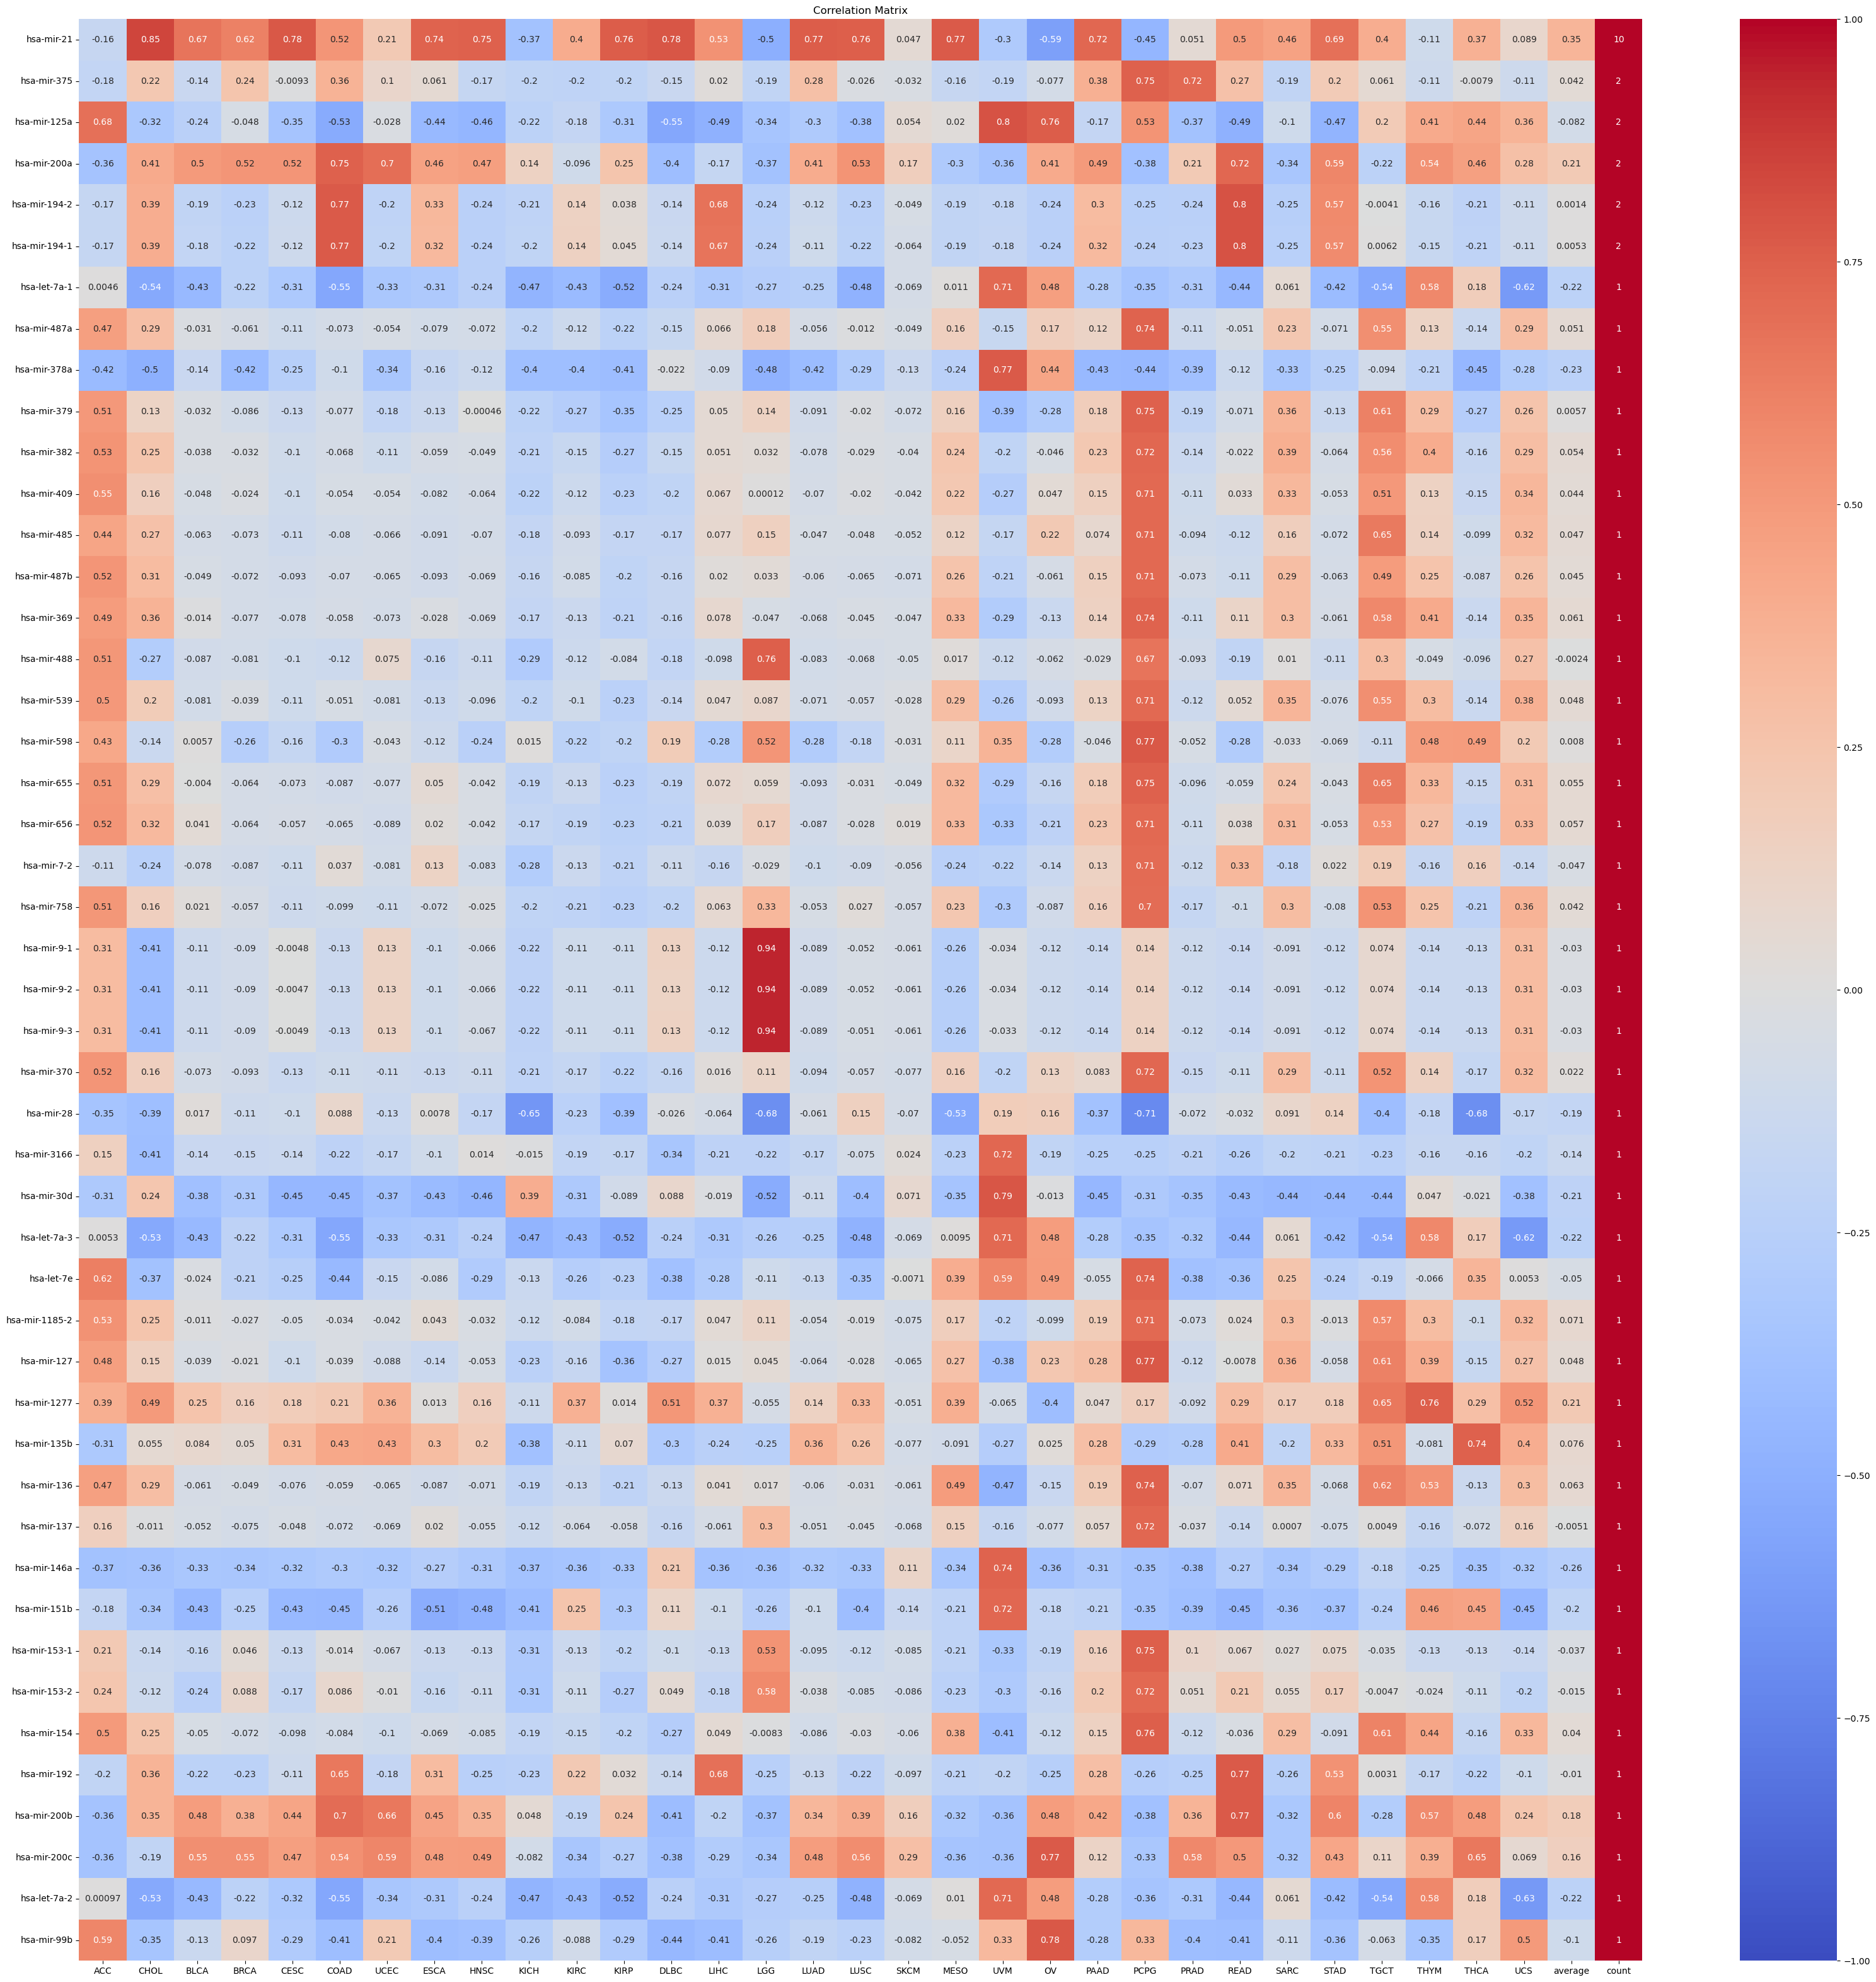

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
# 图的大小
plt.figure(figsize=(40, 40))

sns.heatmap(merged_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()